In [19]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colormaps #type: ignore

In [20]:
model = 'meta-llama/Meta-Llama-3-8B'
model = 'meta-llama/Llama-2-7b-hf'
directory = 'output'
sv = False
dpi = 500
transparent = False
task = 'glue/mrpc'
seed = 42
lr = 2e-6
layers = 14
batch_size = 1
alora_layers = 32
blora_layers = 35

methods = {
    'full': {'lr': 2e-7, 'bs': batch_size, 'layers': 250, 'label': 'full', 'seed': seed},
    # 'alpha_ww': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'alpha_ww', 'seed': seed},
    'alpha_mid_desc': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'alpha_mid_False', 'seed': seed},
    # 'alpha_mid_asc': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'alpha_mid_True', 'seed': seed},
    'layer_desc': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'layer_False', 'seed': seed},
    # 'layer_asc': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'layer_True', 'seed': seed},
    # 'alpha_peak_False': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'alpha_peak_False', 'seed': seed},
    # 'random': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'random', 'seed': seed},
    # 'ww_block': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'ww_block', 'seed': seed},
    # 'peak_block': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'peak_block', 'seed': seed},
    # 'mid_block': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'mid_block', 'seed': seed},
    # 'layer_block': {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': 'layer_block', 'seed': seed},
    # 'lora': {'lr': 2e-5, 'bs': batch_size, 'layers': 0, 'label': 'lora', 'seed': seed},
    # 'alora': {'lr': 2e-5, 'bs': batch_size, 'layers': alora_layers, 'label': 'alora', 'seed': seed},
    # 'blora': {'lr': 2e-5, 'bs': batch_size, 'layers': blora_layers, 'label': 'blora', 'seed': seed},
    # 'adora': {'lr': 2e-5, 'bs': batch_size, 'layers': alora_layers, 'label': 'adora', 'seed': seed},
    # 'layer': {'lr': lr, 'bs': 1, 'layers': layers, 'label': 'layer', 'seed': seed},
    # 'dora': {'lr': 2e-5, 'bs': 4, 'layers': 0, 'label': 'dora', 'seed': seed},
}

seed_list = [42, 43, 44, 45]
alp_seeds = [41, 42, 43, 44, 45]

paths = {}

pth = f'/rscratch/tpang/kinshuk/RpMKin/LlaMAft/Plots/{task}'
if sv:
    print(os.getcwd())
    pth = os.path.join(os.getcwd(), pth)
    Path(pth).mkdir(parents=True, exist_ok=True)
    print(pth)

wide_labels = ['random', 'alpha_ww', 'alpha_mid', 'alpha_peak']
wide_labels = ['random']

task_list = ['alpaca', 'chip2', 'self-instruct', 'hh-rlhf']
task_list = []
for label in wide_labels:
    sd_list = seed_list if 'rand' in label else alp_seeds
    sd = 42
    for sd in sd_list:
        # break
        methods[f'{label}_{sd}'] = {'lr': lr, 'bs': batch_size, 'layers': layers, 'label': label, 'seed': sd, 'task': task}
        paths[f'{label}_{sd}'] = f'./{directory}/{model}/seed_{sd}/{task}/lr_{lr}/batch_{batch_size}/{label}/layers_{layers}'

for k,v in methods.items():
    if k not in wide_labels:
        paths[k] = f'./{directory}/{model}/seed_{methods[k]["seed"]}/{task}/lr_{methods[k]["lr"]}/batch_{methods[k]["bs"]}/{methods[k]["label"]}/layers_{methods[k]["layers"]}'

dictionary = {}
for k,v in paths.items():
    dictionary[k] = {'train_loss': [], 'val_loss': [], 'val_acc':[], 'time': []}
    if directory == 'prelim/output':
        dictionary[k] = {'train_loss': [], 'time': []}

In [21]:
wide_dict = {}
loss = 'train_loss'
loss = 'val_loss'
global_min = np.inf
global_max = -np.inf
line_alpha = 0.1
band_alpha = 0.5

colors = ['xkcd:azure', 'xkcd:goldenrod', 'xkcd:green', 'red', 'purple', 'orange', 'brown', 'black', 'pink', 'cyan', 'magenta']
color_itr = 0

indiv_colors = ['black', 'red', 'xkcd:blue', 'xkcd:orange', 'xkcd:green', 'purple', 'magenta', 'navy', 'cyan', 'xkcd:goldenrod', 'xkcd:azure', 'brown', 'pink']

for label in wide_labels:
    if 'rand' in label:
        line_alpha = 0.1
        band_alpha = 0.3
    wide_dict[label] = {'global_min': np.inf, 'global_max': -np.inf, 'label': label, 'flag': True, 'color': colors[color_itr], 'line_alpha': line_alpha, 'band_alpha': band_alpha}
    color_itr += 1

for key in dictionary.keys():
    path = paths[key]
    path = os.path.join(path, "finetune.npy")
    baseline = np.load(path, allow_pickle=True).item()
    for key2 in dictionary[key].keys():
        dictionary[key][key2].append(baseline[key2])
        dictionary[key][key2] = np.array(dictionary[key][key2]) # type: ignore
    train_loss = dictionary[key][loss][0]
    for label in wide_labels:
        if label in key:
            wide_dict[label]['global_min'] = np.minimum(wide_dict[label]['global_min'], train_loss)
            wide_dict[label]['global_max'] = np.maximum(wide_dict[label]['global_max'], train_loss)
    # # Redundant
    # if 'random' in key:
    #     global_min = np.minimum(global_min, train_loss)
    #     global_max = np.maximum(global_max, train_loss)

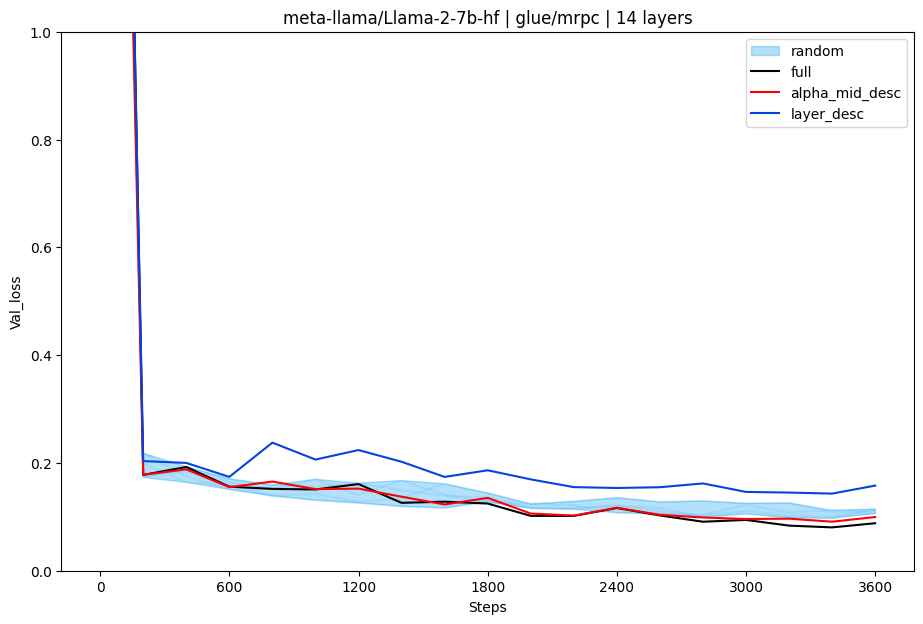

<Figure size 1100x700 with 0 Axes>

In [22]:
color_itr = 0
y_low = 0
y_high = 1
for label in wide_labels:
    wide_dict[label]['flag'] = True
plt.figure(figsize=(11, 7))
for key in dictionary.keys():
    train_loss = dictionary[key][loss][0]
    tag = key
    if 'alora' in key or 'blora' in key:
        tag = key + f"_{methods[key]['layers']} lr={methods[key]['lr']}"
    flag = True
    for label in wide_labels:
        if label in key:
            plt.plot(train_loss, alpha=wide_dict[label]['line_alpha'], color=wide_dict[label]['color'], label='_nolegend_')
            if wide_dict[label]['flag'] == True:
                plt.fill_between(
                    range(len(train_loss)), wide_dict[label]['global_min'], wide_dict[label]['global_max'], 
                    alpha=wide_dict[label]['band_alpha'], color=wide_dict[label]['color'], label=label
                )
                wide_dict[label]['flag'] = False
            flag = False
            break
    if flag == True:
        plt.plot(train_loss, label=tag, color=indiv_colors[color_itr])
        color_itr += 1
num_steps = len(train_loss)
step_interval = 200
x_ticks = list(range(0, num_steps * step_interval, step_interval))
tick_step = 600
if 'val' in loss:
    plt.xticks(range(0, num_steps, tick_step // step_interval), range(0, num_steps * step_interval, tick_step))
plt.xlabel("Steps")
plt.ylabel(f"{loss.capitalize()}")
plt.ylim(y_low, y_high)
# plt.xlim(0, 50)
plt.legend()
plt.title(f"{model} | {task} | {layers} layers")
plt.show()

full_time = 1
color_itr = 0
for label in wide_labels:
    wide_dict[label]['flag'] = True
plt.figure(figsize=(11, 7))
for key in dictionary.keys():
    if 'val' in loss:
        break
    if 'full' in key:
        if full_time == False:
            continue
    train_loss = dictionary[key]['train_loss'][0]
    time_val = dictionary[key]['time'][0]
    tag = key
    if 'alpha' in key or 'alora' in key or 'blora' in key:
        tag = key + f"_{methods[key]['layers']} lr={methods[key]['lr']}"
    flag = True
    for label in wide_labels:
        if label in key:
            plt.plot(time_val, train_loss,alpha=wide_dict[label]['line_alpha'], color=wide_dict[label]['color'], label='_nolegend_')
            if wide_dict[label]['flag'] == True:
                plt.fill_between(
                    time_val, wide_dict[label]['global_min'], wide_dict[label]['global_max'], 
                    alpha=wide_dict[label]['band_alpha'], color=wide_dict[label]['color'], label=label
                )
                wide_dict[label]['flag'] = False
            flag = False
            break
    if flag == True:
        plt.plot(time_val, train_loss, label=tag, color=indiv_colors[color_itr])
        color_itr += 1
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Train_loss")
if 'val' not in loss:
    plt.ylim(y_low, y_high)
    # plt.xlim(0, 15)
    plt.legend()
    plt.title(f"{model} | {task} | {layers} layers")
    plt.show()

# exit()

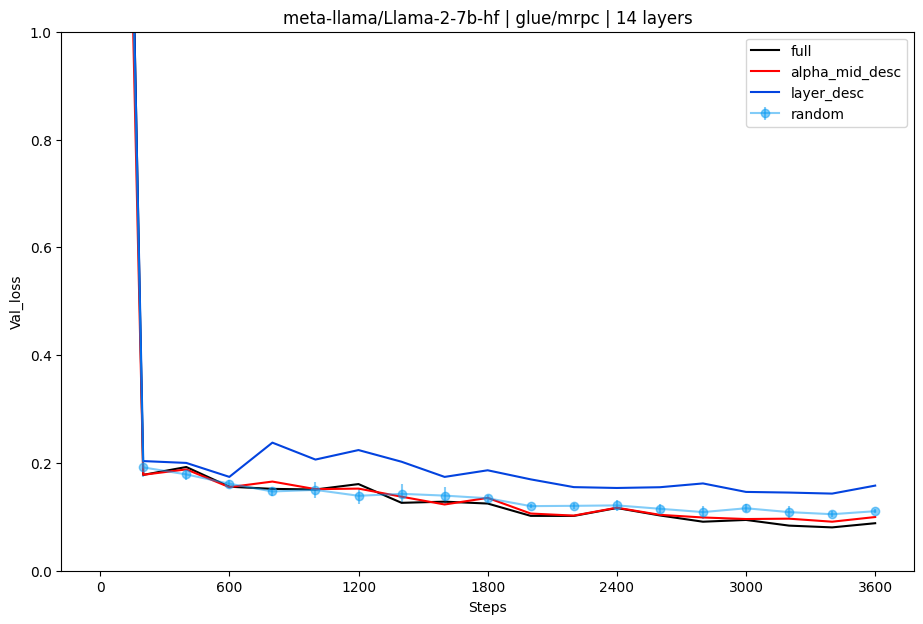

In [23]:
sampling_interval = 1

color_itr = 0
wide_confidence = {}
for label in wide_labels:
    wide_confidence[label] = {
        "losses": [
            dictionary[key][loss][0]
            for key in dictionary.keys()
            if label in key
        ],
        "mean": None,
        "std": None,
        "label": label,
        "flag": True,
        "color": colors[color_itr],
    }
    wide_confidence[label]["mean"] = np.mean(wide_confidence[label]["losses"], axis=0)
    wide_confidence[label]["std"] = np.std(wide_confidence[label]["losses"], axis=0)
    color_itr += 1
color_itr = 0
# Plotting the training loss with error bars representing mean plus/minus standard deviation for wide bands
plt.figure(figsize=(11, 7))
plot_handles = []
plot_labels = []
for key in dictionary.keys():
    train_loss = dictionary[key][loss][0]
    tag = key + f" lr={methods[key]['lr']} bs={methods[key]['bs']}"
    tag = key
    if "alora" in key or "blora" in key:
        tag = key + f"_{methods[key]['layers']} lr={methods[key]['lr']}"
    flag = True
    for label in wide_labels:
        if label in key:
            if wide_confidence[label]["flag"]:
                plt.errorbar(
                    range(0, len(train_loss), sampling_interval),
                    wide_confidence[label]["mean"][::sampling_interval],
                    yerr=wide_confidence[label]["std"][::sampling_interval],
                    fmt="-o", alpha=0.5, label=label, color = 'gray' if 'rand_block' in key else wide_dict[label]['color']
                )
                wide_confidence[label]["flag"] = False
            flag = False
            break
    if flag == True:
        sampled_train_loss = train_loss[::sampling_interval]
        x_values = range(len(train_loss))[::sampling_interval]
        if len(train_loss) % sampling_interval != 0:
            sampled_train_loss = np.append(
                sampled_train_loss, train_loss[-1]
            )  # Add the last value if the length is not divisible by the sampling interval
            x_values = np.append(x_values, len(train_loss) - 1)
        plt.plot(x_values, sampled_train_loss, label=tag, color=indiv_colors[color_itr])
        color_itr += 1
if 'val' in loss:
    plt.xticks(range(0, num_steps, tick_step // step_interval), range(0, num_steps * step_interval, tick_step))
plt.xlabel("Steps")
plt.ylabel(f"{loss.capitalize()}")
plt.ylim(y_low, y_high)
plt.legend()
plt.title(f"{model} | {task} | {layers} layers")
plt.show()

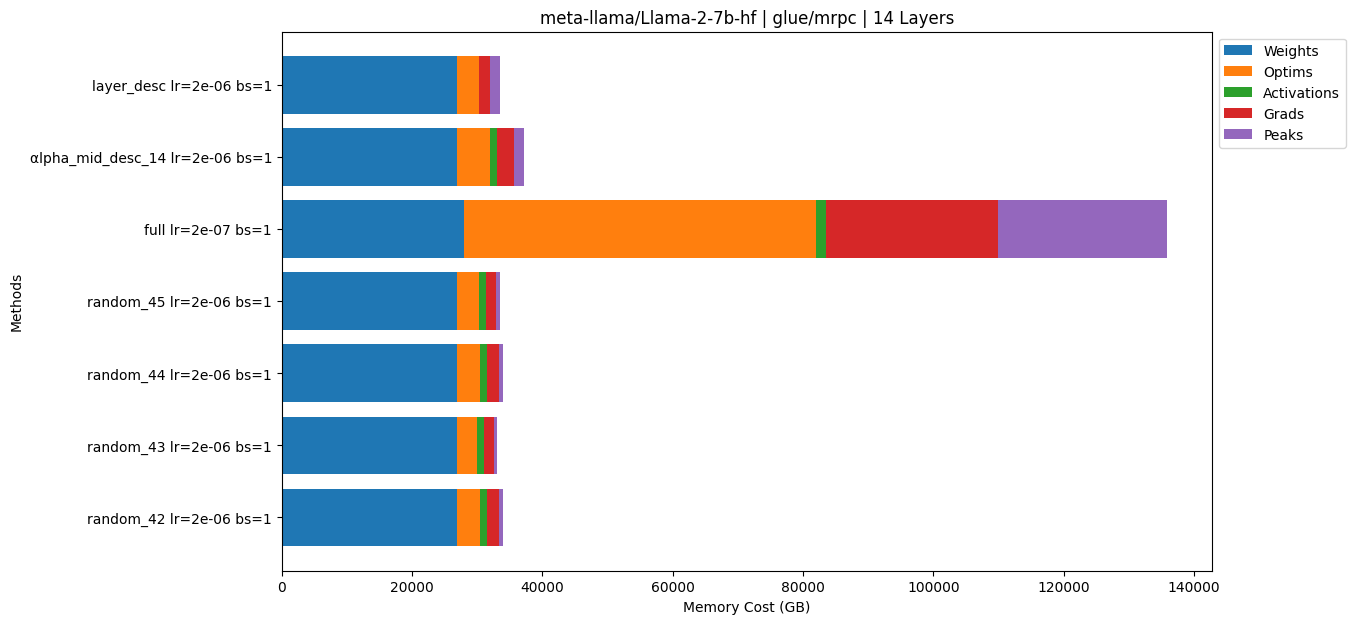

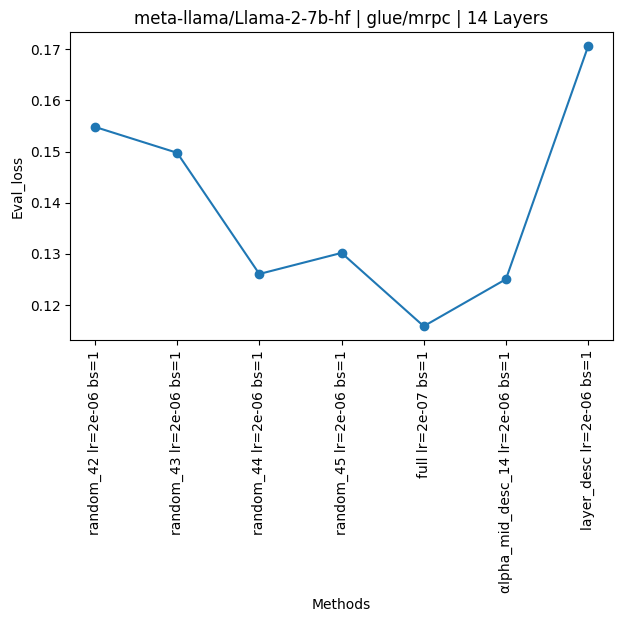

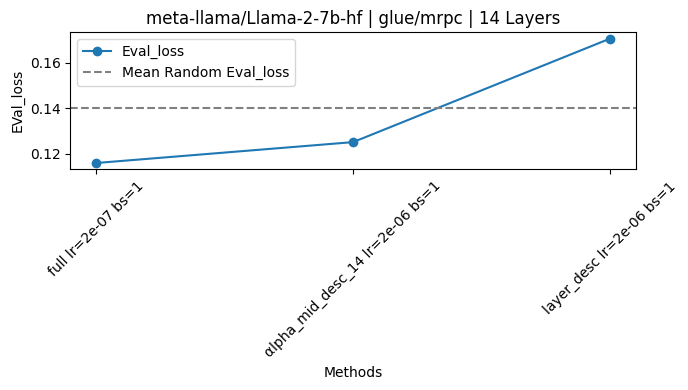

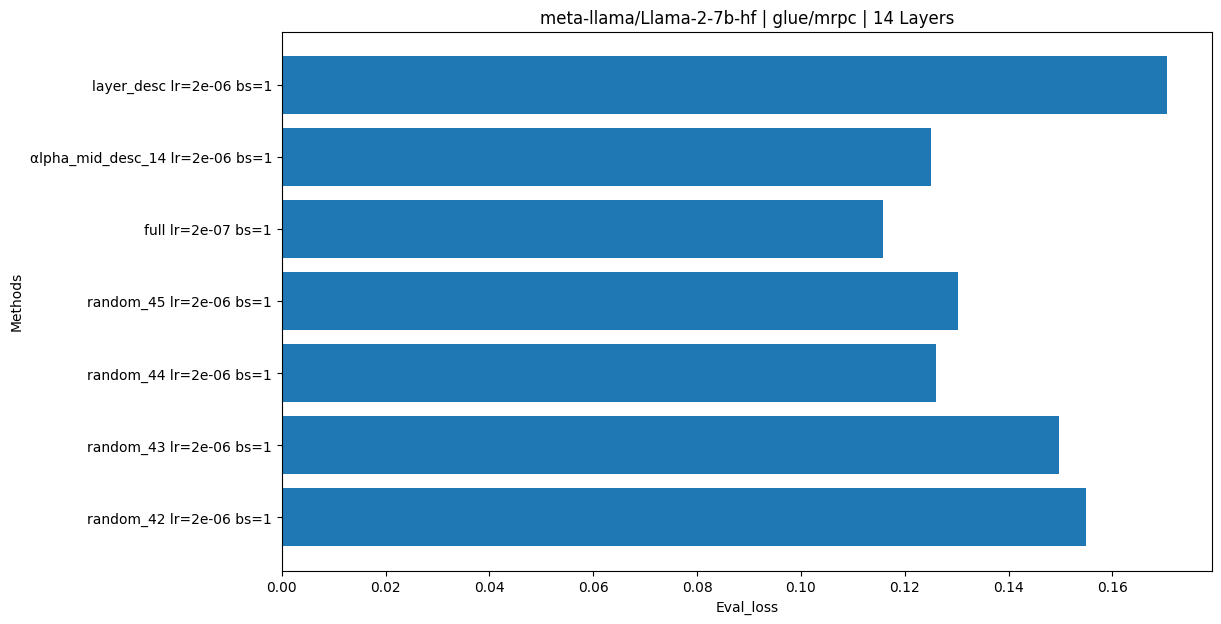

In [24]:
mem_dict = {
    'categories': [],
    'weights': [],
    'optims': [],
    'activations': [],
    'grads': [],
    'peaks': [],
}
if 'val' not in loss:
    loss = 'val_loss'
eval_loss = {}
for key in dictionary.keys():
    tag = key + f" lr={methods[key]['lr']} bs={methods[key]['bs']}"
    if 'alpha' in key or 'alora' in key:
        tag = 'α' + key[1:] + f"_{methods[key]['layers']} lr={methods[key]['lr']} bs={methods[key]['bs']}"
    elif 'blora' in key:
        tag = 'β' + key[1:] + f"_{methods[key]['layers']} lr={methods[key]['lr']} bs={methods[key]['bs']}"
    mem_dict['categories'].append(tag)
    path = paths[key]
    path = os.path.join(path, "stats.json")
    with open(path, 'r') as f:
        data = json.load(f)
    stats = pd.DataFrame([data])
    mem_dict['weights'].append(stats['weight_mem'].mean())
    mem_dict['optims'].append(stats['optimizer_mem'].mean())
    mem_dict['activations'].append(stats['activation_mem'].mean())
    mem_dict['grads'].append(stats['grad_mem'].mean())
    mem_dict['peaks'].append(stats['peak_mem'].mean())
    eval_loss[key] = stats[f'e{loss}'].mean()

for key in mem_dict.keys():
    mem_dict[key] = np.array(mem_dict[key]) # type: ignore
mem_dict['peaks'] = mem_dict['peaks'] - (mem_dict['weights'] + mem_dict['optims'] + mem_dict['activations'] + mem_dict['grads']) # type: ignore

# MEMORY COST
plt.figure(figsize=(12, 7))
left = [0] * len(mem_dict['categories'])
for key in mem_dict.keys():
    if key == 'categories':
        continue
    plt.barh(mem_dict['categories'][:], mem_dict[key][:], left=left[:], label=key[0].upper()+key[1:])
    left += mem_dict[key]
plt.xlabel('Memory Cost (GB)')
plt.ylabel('Methods')
plt.title(f'{model} | {task} | {layers} Layers')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# EVAL LOSS CURVE
plt.figure(figsize=(7, 4))
plt.plot(mem_dict['categories'], [eval_loss[k] for k in dictionary.keys()], marker='o')
plt.xlabel('Methods')
plt.ylabel(f'E{loss}')
plt.title(f'{model} | {task} | {layers} Layers')
plt.xticks(rotation=90)
plt.show()

# MEAN EVAL LOSS FOR 'RANDOM' KEYS
# Calculate mean eval loss of 'random' keys
random_eval_loss = np.mean([eval_loss[k] for k in dictionary.keys() if 'rand' in k])

# Extract categories and eval loss for non-random keys
categories = [cat for cat in mem_dict['categories'] if 'random' not in cat]
eval_losses = [eval_loss[k] for k in dictionary.keys() if 'random' not in k]

# Plot eval_loss for each as a curve
plt.figure(figsize=(7, 4))
plt.plot(categories, eval_losses, marker='o', label=f'E{loss}')

# Add mean eval loss for 'random' keys as a horizontal line
plt.axhline(y=random_eval_loss, color='gray', linestyle='--', label=f'Mean Random E{loss}')

plt.xlabel('Methods')
plt.ylabel(f'E{loss.capitalize()}')
plt.title(f'{model} | {task} | {layers} Layers')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# EVAL LOSS BAR PLOT
# Plot eval_loss for each
plt.figure(figsize=(12, 7))
plt.barh(mem_dict['categories'], [eval_loss[k] for k in dictionary.keys()])
plt.xlabel(f'E{loss}')
plt.ylabel('Methods')
plt.title(f'{model} | {task} | {layers} Layers')
plt.show()

# exit(0)

# Previous exp

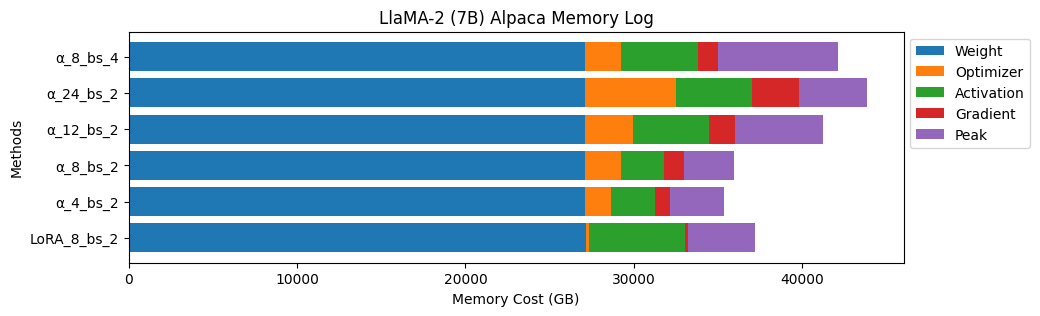

In [25]:
# Alpaca_Data
plt.figure(figsize=(10, 3))
categories = ['LoRA_8_bs_2', 'α_4_bs_2', 'α_8_bs_2', 'α_12_bs_2', 'α_24_bs_2', 'α_8_bs_4']
Weight = [27167.883264, 27087.929344, 27087.929344, 27087.929344, 27087.929344, 27087.929344]
Optimizer =  [159.90784, 1585.47968, 2122.350592, 2885.71392, 5402.29632, 2122.350592]
Activation = [5737.52832, 2575.353344, 2604.649472, 4503.892992, 4546.884608, 4574.863872]
Gradient =   [157.92384, 875.31776, 1143.753216, 1525.43488, 2784.250368, 1193.931264]
Peak = [37186.260992, 35369.175552, 35976.432128, 41205.979136, 43821.993984, 42142.918144]

#Reduce other memory from peak
Weight = np.array(Weight)
Optimizer = np.array(Optimizer)
Activation = np.array(Activation)
Gradient = np.array(Gradient)
Peak = np.array(Peak)
Peak = Peak - (Weight + Optimizer + Activation + Gradient)

plt.barh(categories, Weight, label='Weight')
plt.barh(categories, Optimizer, label='Optimizer',  left=Weight)
plt.barh(categories, Activation, label='Activation',  left=Weight+Optimizer)
plt.barh(categories, Gradient, label='Gradient',  left=Weight+Optimizer+Activation)
plt.barh(categories, Peak, label='Peak',  left=Weight+Optimizer+Activation+Gradient)

# Adding labels and title
plt.xlabel('Memory Cost (GB)')
plt.ylabel('Methods')
plt.title('LlaMA-2 (7B) Alpaca Memory Log')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Displaying the graph
# plt.savefig(f'Alpaca_Memory_log', transparent=transparent, dpi=dpi, bbox_inches='tight')
plt.show()


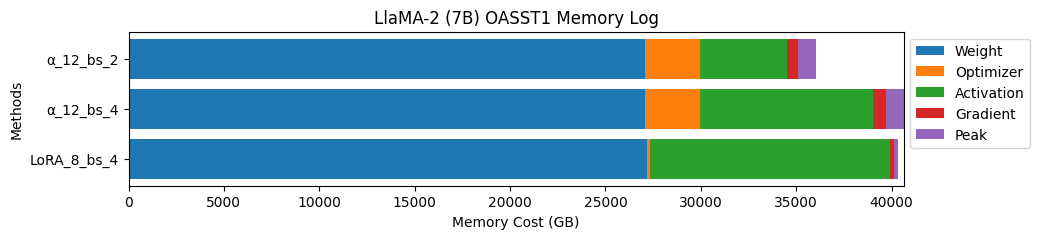

In [26]:
# Alpaca_Data
plt.figure(figsize=(10, 2))
categories = ['LoRA_8_bs_4', 'α_12_bs_4', 'α_12_bs_2']
Weight = [27167.883264, 27087.929344, 27087.929344]
Optimizer =  [159.90784, 2885.71392, 2885.71392]
Activation = [12593.586688, 9063.457792, 4550.16448]
Gradient =   [229.114368, 1592.017408, 1525.691392]
Peak = [40351.6416, 39729.840128, 35118.135808]

#Reduce other memory from peak
Weight = np.array(Weight)
Optimizer = np.array(Optimizer)
Activation = np.array(Activation)
Gradient = np.array(Gradient)
Peak = np.array(Peak)
Peak = Peak - (Weight + Optimizer + Activation + Gradient)

plt.barh(categories, Weight, label='Weight')
plt.barh(categories, Optimizer, label='Optimizer',  left=Weight)
plt.barh(categories, Activation, label='Activation',  left=Weight+Optimizer)
plt.barh(categories, Gradient, label='Gradient',  left=Weight+Optimizer+Activation)
plt.barh(categories, Peak, label='Peak',  left=Weight+Optimizer+Activation+Gradient)

# Adding labels and title
plt.xlabel('Memory Cost (GB)')
plt.ylabel('Methods')
plt.title('LlaMA-2 (7B) OASST1 Memory Log')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Displaying the graph
# plt.savefig(f'OASST1_Memory_log', transparent=transparent, dpi=dpi, bbox_inches='tight')
plt.show()


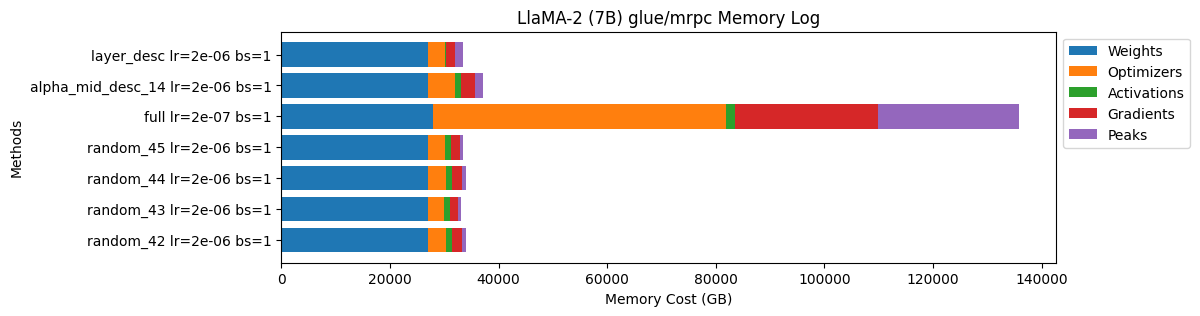

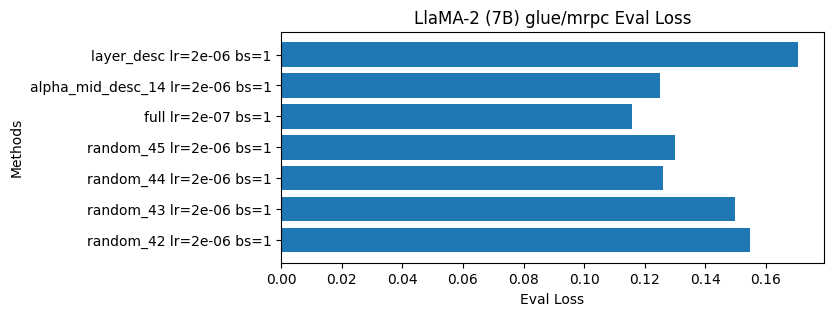

In [27]:
categories = []
weights = []
optims = []
activations = []
grads = []
peaks = []
eval_loss = {}

for key in dictionary.keys():
    tag = key + f" lr={methods[key]['lr']} bs={methods[key]['bs']}"
    if 'alpha' in key or 'alora' in key:
        tag = key + f"_{methods[key]['layers']} lr={methods[key]['lr']} bs={methods[key]['bs']}"
    categories.append(tag)
    path = paths[key]
    path = os.path.join(path, "stats.json")
    with open(path, 'r') as f:
        data = json.load(f)
    stats = pd.DataFrame([data])
    weights.append(stats['weight_mem'].mean())
    optims.append(stats['optimizer_mem'].mean())
    activations.append(stats['activation_mem'].mean())
    grads.append(stats['grad_mem'].mean())
    peaks.append(stats['peak_mem'].mean())
    eval_loss[key] = stats[f'e{loss}'].mean()

categories = np.array(categories)
weights = np.array(weights)
optims = np.array(optims)
activations = np.array(activations)
grads = np.array(grads)
peaks = np.array(peaks)
eval_loss = np.array([eval_loss[k] for k in dictionary.keys()])
peaks = peaks - (weights + optims + activations + grads) # type: ignore

plt.figure(figsize=(10, 3))
plt.barh(categories, weights, label='Weights')
plt.barh(categories, optims, left=weights, label='Optimizers')
plt.barh(categories, activations, left=weights + optims, label='Activations')
plt.barh(categories, grads, left=weights + optims + activations, label='Gradients')
plt.barh(categories, peaks, left=weights + optims + activations + grads, label='Peaks')
# Adding labels and title
plt.xlabel('Memory Cost (GB)')
plt.ylabel('Methods')
plt.title(f'LlaMA-2 (7B) {task} Memory Log')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# Plot eval_loss for each
plt.figure(figsize=(7, 3))
plt.barh(categories, eval_loss)
plt.xlabel('Eval Loss')
plt.ylabel('Methods')
plt.title(f'LlaMA-2 (7B) {task} Eval Loss')
plt.show()